# LES with Nested Grids

The aim of this project is to allow higher time and space resolution on parts of the domain.

## Nested versus piecewise constant 

Proper nesting means that for part of a domain, a finer grid is used than for the rest of the domain:             

```python
        if x_n_b < x < x_n_e and y_n_b < x < y_n_e:
                dx = DXN
                dy = DYN
        else:
                dx = DXP
                dy = DYP
```        

Piecewise constant means that for part of a domain, a finer grid is used than for the rest of the domain, but as follows:             

```python
            if x_n_b < x < x_n_e
                    dx = DXN
            else:
                    dx = DXP
            if y_n_b < x < y_n_e:        
                    dy = DYN
            else:
                    dy = DYP    
```        

The latter approach is much simpler but has some overhead:

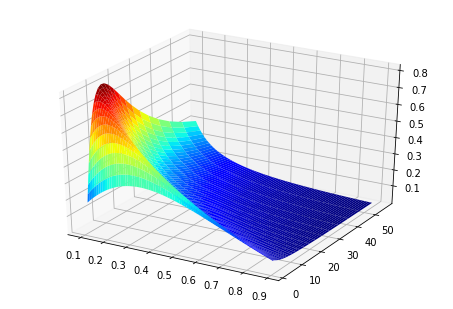

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy #as np
from matplotlib import cm
from matplotlib import pyplot as plt
alpha,kk = numpy.mgrid[0.1:0.9:0.01,1:6:.2]

k = 2**kk #)/numpy.log(2)
overhead = (2*alpha*(1-alpha)*(k-1))/(1+alpha*alpha*(k*k-1))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(alpha,k,overhead,rstride=1,cstride=1,cmap=cm.jet)
plt.show()

The figure shows the overhead (additional fraction of grid points required) for the parameters $k$ and $\alpha$, respectively the increase in linear density of the nested grid compared to the original grid, and the linear ratio of the nested portion to the total domain. If we assume, without loss of generality, that the domain is square, and assuming the orginal resp nested domains have a linear size $m_0$ resp $m_1$ and linear grid point count of $k_0$ resp $k_1$ then the definitions for $k$ and $\alpha$ are:
$$
k = k_1 / k_0 \\
\alpha = m_1 / m_0
$$

For a typical case where the nested grid would e.g. be 50% of the linear size and have a 10x finer granularity, the overhead would be 17.5%:

In [2]:
alpha = 0.5
k = 10.0
print( 'Overhead: %2.1f%%' % ((100*2*alpha*(1-alpha)*(k-1))/(1+alpha*alpha*(k*k-1))) )

Overhead: 17.5%


## Piecewise constant grid for the MPI LES

If we assume as a starting point a pwc grid for the MPI version of the LES, this simplifies the code a lot: the nested grid requires interpolation and therefore conditions on the boundaries with the nested subdomain. 

For a single grid, there are already 9 different conditions; with a nested grid, the total number of conditions would be 3*8+2 = 26 conditions.

The pwc grid only requires to set the grid spacing dependent on the MPI process: every process represents a sub-grid with identical dimensions. 

For example, if the original grid would be 300x300 and we replace the inner 1/3 with a 10x higher resolution, we obtain a 1200x1200 grid: 100 + 10x100 + 100 in each direction.

In general, if the original grid is $m_0 \times n_0$ and the nested grid is $m_1 \times n_1$, and the resolution increase is $k$, then the new grid size is 

$$
(m_0 - m_1) + k.m_1\;\times\;(n_0 - n_1) + k.n_1
$$

We can split this into 12x12 subgrids of 100x100. Then the subgrid spacing is determined by the subgrid coordinate:
```python
        if (i_s == 0 or i_s == 11): 
            j_sgs = dx
        else:
            i_sgs = dx/10
        if (j_s == 0 or j_s == 11): 
            j_sgs = dy
        else:
            j_sgs = dy/10
```

Or again generalised, assuming the nested grid is placed in the middle of the original domain:

$$
n_{s,i} = 2.((m_0 - m_1) + k.m_1) / (m_0 - m_1)\\
n_{s,j} = 2.((n_0 - n_1) + k.n_1) / (n_0 - n_1)
$$


The subgrid size in this case is

$$
m_s = ((m_0 - m_1) + k.m_1) / n_{s,i} = (m_0 - m_1) / 2\\
n_s = ((n_0 - n_1) + k.n_1) / n_{s,j} = (n_0 - n_1) / 2
$$

If the original grid spacing is $\Delta x$ then the grid spacing for the nested grid is $\Delta x/k$.


Every process is identified by its subgrid coordinates $i_s,j_s$ so that the pwc case only requires adapt the grid spacing for the process and the time step for the process based on the coordinates. 

### Grid spacing adaptation

This is a static operation: when the process starts, it populates the grid spacing arrays based on the subgrid coordinates. This is done in `grid.f95`

```fortran
        if (isMaster()) then
            do i=-1,(ip*procPerCol)+1
                dx1Tot(i) = dxgrid
            end do
        end if
        call distribute1DRealRowWiseArray(dx1Tot,dx1, 2, 1, procPerRow)
```

where `procPerCol` and `dxgrid` are defined in `params_common_sn.f95`, and similar for `dylTot`. So we need `dxgrid_orig` and `dxgrid_nest` in `params_common_sn.f95`.

### Time step adaptation

This is a bit more tricky: given the subgrid coordinates we can easily and statically set the time step (`dt_orig` and `dt_nest`, to be defined in  `params_common_sn.f95`) in `set.f95` but it is a bit more complicated to do syncing.

For sending/receiving, we need to determine in which grid the source and the destination are.


If sender and receiver are both in the nested grid then sync on every time step `dt_nest` otherwise sync on every time step `dt_orig`. 

So if we have `n` ticks in the nest for 1 tick in the orig, then we need to count `n` ticks in the nest before we can send.
In other words, we need to have a counter in nest which gets reset on hitting `dt_orig`, and we sync either on the first or on the last step.

This also means that all calls that send/receive must have access to the tick. 

What we do is keep the tick constant for the orig domain and decrement for the nested domain. So, in the main timeloop, we do as follows:

```fortran        
        if (inNestedGrid()) then 
            ticks = ticks+1
            if (ticks == dt_nest/dt_orig) ticks = 0
        else
            ticks = 0
        end if
```        

So we need to change the subroutines `exchangeRealHalos` and `exchangeRealCorners` in `communication_helper_real` to include the tick, and predicate the sending/receiving on it. 

<!--
- To send from a process in the nested domain to a process in the orig domain only happens when `ticks == 0`.
- To send from a process in the nested domain to a process in the nested domain happens on all ticks
- To send from a process in the orig domain to a process in the nested domain happens on all ticks
- To send from a process in the orig domain to a process in the orig domain happens on all ticks

- To receive from a process in the orig domain by a process in the nested domain happens when `ticks == 0`
- To receive from a process in the nested domain by a process in the orig domain only happens on all ticks
- To receive from a process in the nested domain by a process in the nested domain happens on all ticks
- To receive from a process in the orig domain by a process in the orig domain happens on all ticks
-->

```fortran
        if (inNested() .and. .not. inNestedGridByRank(commWith) then
            if (ticks == 0) then
                    ! populate buffer
                    MPI_ISend(...)
                    MPI_IRecv(...)
            end if
        else
            MPI_ISend(...)/MPI_IRecv(...)
        end if     
```

#### What about `MPI_allreduce()` calls?

The `MPI_allreduce` call used in e.g. `getGlobalMaxOf` does not need syncing, so we don't need ticks. 

#### Subgrid coordinates

So the key question is: what about those subgrid coordinates? 

The LES code uses `procPerCol,procPerRow` and the grid in each proc is of size `ip,jp`. The identifier for each MPI process is `rank` and the total number of processes (the Master is just one of them) is `mpi_size` which I guess is 


        mpi_size = procPerCol*procPerRow
        
So the subgrid coordinates become:

```fortran
    subroutine calcSubgridCoords(procPerRow,rank,i_s,j_s) 
        integer, intent(In) :: procPerRow, rank
        integer, intent(Out) :: i_s,j_s
        i_s = rank / procPerRow ! => row, base 0
        j_s = rank % procPerRow !=> column, base 0
    end subroutine calcSubgridCoords    
```

Then we create a function `inNestedGrid()` which tells us which grid we're in for the current rank, and a function `inNestedGridByRank(rank)` for any rank.

```fortran
    pure logical function inNestedGrid() result(in_grid)
            integer :: i_s, j_s
            call 
            in_grid = calcSubgridCoords(procPerRow,rank,i_s,j_s) 
    end function inNestedGrid
```

This very easy for 2 grids. For more grids we need to number then and then have `inGrid()` and `inGridByRank(rank)` return the number.



## Issues with current LES code

- In `bondv1`, the routines `gatheraaa` and `gatherbbb` from `communication_helper_real` are called.

    - These routines compute  `max(aaa)` resp. `min(bbb)` over the bottom subgrid row. I wonder why that is, should it not be over the full subgrid?
    - Also, why not do this using `MPI_AllReduce()` on a custom communicator? 
    - Why was `getGlobalMaxOf(aaa)` replaced with `gatheraaa`?     
    
```fortran
MPI_AllReduce(send_data, recv_data, send_recv_count, send_recv_datatype, op, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_recv_count, send_recv_datatype 
    integer ::    op, comm, ierror    
    
MPI_IAllReduce(send_data, recv_data, send_recv_count, send_recv_datatype, op, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_recv_count, send_recv_datatype 
    integer ::    op, comm, req, ierror  
```

- In `anime`, subroutine `distributeu(ua, u,ip, jp, kp, ipmax, jpmax, procPerRow)` sends `u` for every process to the master, which aggregates the portions into the global-sized array `ua`. This is OK for a small number of processes and/or small `ip*jp*kp` but is not scalable to large problems.

- In `ifdata`, subroutine `distributeifu(ua, ip, jp, kp, ipmax, jpmax, procPerRow)` does the opposite, it sends portions of the large array `ua` to all processes. Again, this is not scalable?


- This happens in following routines:
    - `ifdata` (called only once): `u`,`v`,`w`,`p`,`usum`,`vsum`,`wsum`,`f`,`g`,`h`,`fold`,`gold`,`hold` 
    - `anime`, `ifdata_out` (called every 20 time steps, `avetime=20`): same plus `uani`,`vani`,`wani` and `pani` 
    - `aveflow` (called only once at the end): `aveu`, `avew`, `avev`, `avep`, `aveuu`, `aveww`, `avevv`, `uwfx`
    
- Other routines that do a similar operation are:
    - `feedbfm` (called only once, in `init`): `zbm`
    - `bondv1_data24`: seems unused    
    
- The routine `grid` is a special case, called only once, and the arrays are 1-D so small, this is OK:
        
```fortran
        call distribute1DRealRowWiseArray(dx1Tot,dx1, 2, 1, procPerRow)
        call distribute1DRealRowWiseArray(dxlTot,dxl, 1, 0, procPerRow)
        call distribute1DRealColumnWiseArray(dy1Tot, dy1, 1, 1, procPerRow)
        call distribute1DRealColumnWiseArray(dylTot, dyl, 1, 0, procPerRow)
```    

With regards to the size, every one of these arrays is `4*ip*jp*kp`. Considering all the above we'd need storage 26 such arrays, so let's round this up to 32 as total memory requirement.
Assuming a typical node has 64GB of memory, then each array can be at most 2GB. With `kp=80`, and assume `ip=jp` this means `ip*ip = 2*1024/4/80M` or `ip*ip = 6.4` so `ip < 2.5K`. 

So it is sufficient that the master is run on a large-memory instance to make this work. 

- But this requires a change to the current code: we must dynamically allocate memory only on the master node, not on the other nodes. At the moment, all these large arrays are static.

Even if this is acceptable in terms of scalability, it would surely be better to use `MPI_scatter` and `MPI_gather` for this?

```fortran
MPI_Scatter(send_data, send_count, send_datatype, recv_data, recv_count, recv_datatype, root, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer, intent(In) ::    send_count, send_datatype, recv_count, recv_datatype, root
    integer, intent(InOut) ::    comm, ierror
    
MPI_IScatter(send_data, send_count, send_datatype, recv_datatype, recv_count,recv_datatype, root, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, RECVTYPE, root
    integer ::    comm, req, ierror
    
MPI_Gather(send_data, send_count, send_datatype, recv_data, recv_count, recv_datatype, root, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, recv_datatype, root
    integer ::    comm, ierror
    
MPI_IGather(send_data, send_count, send_datatype, recv_datatype, recv_count,recv_datatype, root, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, RECVTYPE, root
    integer ::    comm, req, ierror
    
```

Using these functions has the advantage of simplifying the code, for example for `anime` we'd get:
    
```fortran
    count = ip*jp*kp
    MPI_Gather(per_proc_array, count, MPI_REAL, glob_array, count, MPI_REAL, master_rank, communicator, ierror)
```

And for `ifdata` we'd get:

```fortran
    count = ip*jp*kp
    MPI_Scatter(per_proc_array, count, MPI_REAL, glob_array, count, MPI_REAL, master_rank, communicator, ierror)
```

This will work if the rank of the processes reflects a cartesian grid, and as we use `MPI_Cart_Create` this should be the case. 

### MPI on MacOs

- MacPorts: Install OpenMPI for gfortran 4.9
    
        $ port install openmpi-gcc49 +fortran
        
        
          openmpi-gcc49 has the following notes:
            The mpicc wrapper (and friends) are installed as:

              /opt/local/bin/mpicc-openmpi-gcc49 (likewise mpicxx, ...)

            To make openmpi-gcc49's wrappers the default (what you get when
            you execute 'mpicc' etc.) please run:

              sudo port select --set mpi openmpi-gcc49-fortran     
              
- MacPorts: Install NetCDF for gfortran 4.9              
              
        $ port install netcdf-fortran +gcc49                      

          netcdf has the following notes:
            As of version 4.2 c++ and fortran interfaces are separate ports, netcdf-cxx and netcdf-fortran, respectively.              
              
- Changes in `Sconstruct`:

```python
        if OSX==0:    
            envF.Append(LIBS=['netcdf']) # for version less than 4.2.0
        else:
        #WV: OpenMPI puts the Fortran functionality in libmpi_mpifh.dylib
            envF.Append(LIBS=['mpi_mpifh','netcdff']) # for version more than and equal to 4.2.0
            
        if OSX == 1:
        # Assuming MacPorts
        #WV: For OpenMPI, the module mpi.mod is in the /lib/ folder, so I have to add this to the INCLPATH
            INCLPATH = ['/opt/local/include','/opt/local/include/openmpi-gcc49/','/opt/local/lib/openmpi-gcc49/']
            LIBPATH = ['/opt/local/lib','/opt/local/lib/openmpi-gcc49/']
```

- To build the code:

        [src]$ scons ocl=0 mpi=1 procPerRow=4 procPerCol=4
        
- And to run this:

        [src]$ mpiexec-openmpi-gcc49 -np 16 ./les_main_mpi
        
- I also installed MPICH for gfortran-7 but haven't tested it, nor installed the corresponding NetCDF        

        $ port install mpich-gcc7 +fortran
        
          mpich-gcc7 has the following notes:
            +--- MPICH Usage note ----
            | The mpicc wrapper (and friends) are installed as:
            |
            |   /opt/local/bin/mpicc-mpich-gcc7 (likewise mpicxx, ...)
            |
            | To make mpich-gcc7's wrappers the default (what you get when
            | you execute 'mpicc' etc.) please run:
            |
            |   sudo port select --set mpi mpich-gcc7-fortran
            +-------------------------
            
